In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, f1_score
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import config



In [ ]:
# connect the google drive to you colab for data acess
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to your dataset
IMAGE_DIR = '/content/drive/My Drive/DatasetBreasts/DS/Original'  # Replace with your images directory
MASK_DIR = '/content/drive/My Drive/DatasetBreasts/DS/Mask'    # Replace with your masks directory

# Image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1  # Grayscale images; set to 3 for RGB

# Training parameters
BATCH_SIZE = 16
EPOCHS = 50


In [ ]:
def load_images(image_dir, mask_dir, img_height, img_width):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)
                          if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)
                         if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        # Load and resize image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)

        # Load and resize mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_width, img_height))
        mask = mask / 255.0  # Normalize to [0,1]
        mask = np.where(mask > 0.5, 1, 0)  # Binarize
        masks.append(mask)

    images = np.array(images).reshape(-1, img_height, img_width, 1)
    masks = np.array(masks).reshape(-1, img_height, img_width, 1)
    return images, masks

# Load data
X, Y = load_images(IMAGE_DIR, MASK_DIR, IMG_HEIGHT, IMG_WIDTH)

print(f"Total images: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")
print(f"Mask shape: {Y.shape[1:]}")


Total images: 283
Image shape: (256, 256, 1)
Mask shape: (256, 256, 1)


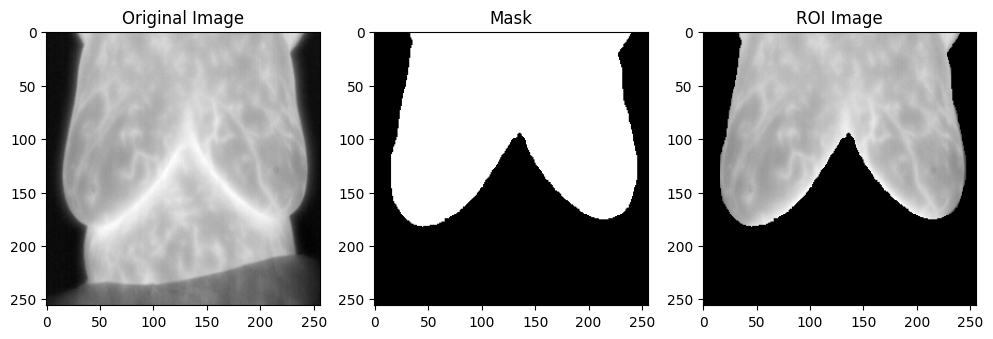

In [ ]:
def apply_roi(images, masks):
    roi_images = images * masks  # Element-wise multiplication
    return roi_images

# Apply ROI reduction
X_roi = apply_roi(X, Y)

# Optional: Visualize ROI reduction
def visualize_roi(image, mask, roi_image):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(image.squeeze(), cmap='gray')

    plt.subplot(1,3,2)
    plt.title('Mask')
    plt.imshow(mask.squeeze(), cmap='gray')

    plt.subplot(1,3,3)
    plt.title('ROI Image')
    plt.imshow(roi_image.squeeze(), cmap='gray')
    plt.show()

# Visualize the first sample
visualize_roi(X[0], Y[0], X_roi[0])


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_roi, Y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 226
Testing samples: 57


In [ ]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_breast_segmentation.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

# Train the model with 10 epochs
history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=10,  # Run only 10 epochs
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/10
13/13 [==============================] - 116s 9s/step - loss: 0.3270 - accuracy: 0.9976 - val_loss: 0.3096 - val_accuracy: 0.9978
Epoch 2/10
13/13 [==============================] - 115s 9s/step - loss: 0.3264 - accuracy: 0.9979 - val_loss: 0.3091 - val_accuracy: 0.9985
Epoch 3/10
13/13 [==============================] - 116s 9s/step - loss: 0.3258 - accuracy: 0.9982 - val_loss: 0.3088 - val_accuracy: 0.9989
Epoch 4/10
13/13 [==============================] - 115s 9s/step - loss: 0.3253 - accuracy: 0.9983 - val_loss: 0.3081 - val_accuracy: 0.9986
Epoch 5/10
13/13 [==============================] - 115s 9s/step - loss: 0.3249 - accuracy: 0.9985 - val_loss: 0.3077 - val_accuracy: 0.9989
Epoch 6/10
13/13 [==============================] - 115s 9s/step - loss: 0.3258 - accuracy: 0.9975 - val_loss: 0.3088 - val_accuracy: 0.9986
Epoch 7/10
13/13 [==============================] - 115s 9s/step - loss: 0.3248 - accuracy: 0.9981 - val_loss: 0.3072 - val_accuracy: 0.9981
Epoch 8/10
13

In [ ]:
# Predict on test set
Y_pred = model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Flatten the arrays for metric calculations
Y_test_flat = Y_test.flatten()
Y_pred_flat = Y_pred_binary.flatten()

# Calculate metrics
accuracy = accuracy_score(Y_test_flat, Y_pred_flat)
precision = precision_score(Y_test_flat, Y_pred_flat)
recall = recall_score(Y_test_flat, Y_pred_flat)
jaccard = jaccard_score(Y_test_flat, Y_pred_flat)
dice = f1_score(Y_test_flat, Y_pred_flat)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Jaccard Index (IoU): {jaccard:.4f}")
print(f"Dice Coefficient: {dice:.4f}")


2/2 [==============================] - 6s 2s/step
Accuracy: 0.9987
Precision: 0.9997
Recall: 0.9975
Jaccard Index (IoU): 0.9972
Dice Coefficient: 0.9986


In [ ]:
def save_comparison_images(X, Y_true, Y_pred, save_dir, num_samples=5):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i in range(num_samples):
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.title('Original Image')
        plt.imshow(X[i].squeeze(), cmap='gray')

        plt.subplot(1,3,2)
        plt.title('Ground Truth Mask')
        plt.imshow(Y_true[i].squeeze(), cmap='gray')

        plt.subplot(1,3,3)
        plt.title('Predicted Mask')
        plt.imshow(Y_pred[i].squeeze(), cmap='gray')

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'comparison_{i}.png'))
        plt.close()

# Save comparison images
save_comparison_images(X_test, Y_test, Y_pred_binary, save_dir='comparison_images', num_samples=10)


In [ ]:
def load_unseen_images(unseen_image_dir, img_height, img_width):
    image_files = sorted([os.path.join(unseen_image_dir, f) for f in os.listdir(unseen_image_dir)
                          if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

    images = []
    for img_path in image_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0
        images.append(img)

    images = np.array(images).reshape(-1, img_height, img_width, 1)
    return images, image_files

# Path to unseen images
UNSEEN_IMAGE_DIR = 'path_to_unseen_images'  # Replace with your unseen images directory

# Load unseen images
X_unseen, unseen_image_paths = load_unseen_images(UNSEEN_IMAGE_DIR, IMG_HEIGHT, IMG_WIDTH)

# Apply ROI reduction if masks for ROI are available; assuming you have ROI masks for unseen images
# If not, you might need to skip this or use a predefined ROI mask
# For demonstration, we'll assume the entire image is the ROI
X_unseen_roi = X_unseen  # Replace with ROI application if masks are available

# Predict masks for unseen images
Y_unseen_pred = model.predict(X_unseen_roi)
Y_unseen_pred_binary = (Y_unseen_pred > 0.5).astype(np.uint8)

# Save predicted masks
def save_masks(Y_pred, image_paths, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for pred, img_path in zip(Y_pred, image_paths):
        mask = (pred.squeeze() * 255).astype(np.uint8)
        filename = os.path.basename(img_path)
        mask_path = os.path.join(save_dir, f'mask_{filename}')
        cv2.imwrite(mask_path, mask)

save_masks(Y_unseen_pred_binary, unseen_image_paths, save_dir='unseen_masks')


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_unseen_images'